In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from primesieve import *

from numba import njit, jit
from itertools import permutations

import random

In [20]:
B = 25
SHINGLES = 2
PERMUTATIONS = 100 # how many permutations / hashes you want
TRESHOLD = 0.7

print(1 - np.power((1 - np.power(TRESHOLD, PERMUTATIONS / B)), B))
print(PERMUTATIONS/B)

0.9989554935822509
4.0


In [21]:
df = pd.read_csv("news_articles_small.csv")
# df = pd.read_csv("news_articles_large.csv")

print(df.head())

   News_ID                                            article
0        0  The Supreme Court in Johnnesberg on Friday pos...
1        1  The IG Metall union has decided not to spread ...
2        2  Malaysia said Friday it had no plans to overre...
3        3  South Korea is redoubling its efforts behind K...
4        4  The Philippine subsidiary of US telecommunicat...


# Jaccard similarity

In [22]:
shingles = SHINGLES
shingles_dict = dict()

In [23]:
# convert articles into sets of shingles.
def apply_shingles(input):
    s = set()
    l = input.split(' ')
    for ind in range((len(l) - shingles + 1)):
        word = ' '.join(l[ind:ind+shingles])
        if word not in shingles_dict:
            shingles_dict[word] = len(shingles_dict)
        s.add(shingles_dict[word])
    return s
        
df["shingles"] = df["article"].apply(apply_shingles)
print(df.head())

   News_ID                                            article  \
0        0  The Supreme Court in Johnnesberg on Friday pos...   
1        1  The IG Metall union has decided not to spread ...   
2        2  Malaysia said Friday it had no plans to overre...   
3        3  South Korea is redoubling its efforts behind K...   
4        4  The Philippine subsidiary of US telecommunicat...   

                                            shingles  
0  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  
1  {512, 513, 514, 515, 516, 517, 518, 519, 520, ...  
2  {526, 527, 528, 529, 530, 531, 532, 533, 534, ...  
3  {1, 5, 554, 555, 556, 557, 558, 45, 560, 561, ...  
4  {1024, 1025, 1026, 1027, 1028, 1029, 1030, 103...  


In [24]:
# function to calculate jaccard similarity
def similarity(a, b):
    return (len(a & b) / len(a | b))

In [25]:
%%time
# calculate similarity between all documents, plot in histogram
similarities = list()
no_repeating = set()
for ind_i, i in enumerate(df["shingles"]):
    for ind_j, j in enumerate(df["shingles"]):
        if (ind_j, ind_i) in no_repeating:
            pass
        else:
            no_repeating.add((ind_i, ind_j))
            if ind_i != ind_j:
                similarities.append(similarity(i, j))

hist = np.histogram(similarities, bins=10, range=(0, 1))

CPU times: user 7.72 s, sys: 0 ns, total: 7.72 s
Wall time: 7.72 s


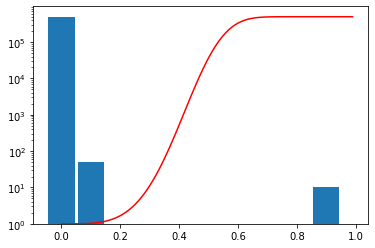

CPU times: user 327 ms, sys: 4.05 ms, total: 331 ms
Wall time: 327 ms


In [70]:
%%time
# draw histogram
fig, ax = plt.subplots()
ax.bar(hist[1][:-1], hist[0], width=0.09)
ax.set_yscale("log")
x = [i/100 for i in range(0, 100)]
ax.plot(x, np.power(10, (1 - np.power((1 - np.power(x, PERMUTATIONS / B)), B)) * np.log10(hist[0][0])), "r")
plt.ylim(bottom=1)
plt.show()

In [27]:
# print histogram distribution to see actual values
print(hist)

(array([499439,     51,      0,      0,      0,      0,      0,      0,
            0,     10]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


# Create minhash

In [28]:
# set up parameters
num_perm = PERMUTATIONS
all_shingles = np.array(list(shingles_dict.values()))

In [73]:
%%time
def make_permutations():
    permutations = np.zeros(shape=(num_perm, len(all_shingles)), dtype=int)
    for i in range(num_perm):
        cont = True
        while cont:
            cont = False
            perm = np.random.permutation(all_shingles)
            for j in range(i):
                if (permutations[j] == perm).all():
                    cont = True
        permutations[i] = perm
    return permutations

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 22.4 µs


In [74]:
%%time
def make_sign_matrix_permu(permutations=make_permutations()):
    sign_matrix = np.zeros(shape=(num_perm, len(df.shingles)), dtype=int)
    for doc_index, document in enumerate(df.shingles):
        for perm_index, perm in enumerate(permutations):
            for shingle_index, shingle in enumerate(perm):
                if shingle in document:
                    sign_matrix[perm_index, doc_index] = shingle_index
                    break
    return sign_matrix

CPU times: user 823 ms, sys: 20 ms, total: 843 ms
Wall time: 841 ms


In [75]:
%%time
class Hash:
    def __init__(self, a, b, p, len_shingles):
        self.a = a
        self.b = b
        self.p = p
        self.len_shingles = len_shingles

    def __call__(self, *args, **kwargs):
        return ((self.a * args[0] + self.b) % self.p) % self.len_shingles

def make_hashes():
    p = n_primes(1,len(all_shingles))[0]
    hashes = []
    len_shingles = len(all_shingles)
    for i in range(num_perm):
        a = np.random.randint(1, p-1)
        b = np.random.randint(0, p-1)

        hashes.append(Hash(a,b,p,len_shingles))
    return hashes

CPU times: user 51 µs, sys: 1 µs, total: 52 µs
Wall time: 59.8 µs


In [77]:
%%time
def make_sign_matrix_hash(hashes=make_hashes()):
    sign_matrix = np.zeros(shape=(num_perm, len(df.shingles)), dtype=int)
    for doc_index, document in enumerate(df.shingles):
        for hash_index, hash in enumerate(hashes):
            min = float('inf')
            for shingle in document:
                tmp = hash(shingle)

                if tmp < min:
                    min = tmp
            sign_matrix[hash_index, doc_index] = min
    return sign_matrix

CPU times: user 930 µs, sys: 0 ns, total: 930 µs
Wall time: 936 µs


In [33]:
print(sign_matrix)

[[ 720  389 1013 ... 2233  158   30]
 [ 705  267 1530 ...  192  557  943]
 [ 353  132  306 ...  434   70  908]
 ...
 [1060   33 1078 ...  402 2614  506]
 [ 321  480  541 ...  273 1132  226]
 [ 216   68   46 ...  350   78  173]]


# Locality-Sensitive Hashing

In [34]:
bands = B

In [35]:
table = np.split(tmp_sign_matrix, bands)
htable = [dict()] * bands

candidate_pairs = set()

In [36]:
print(table[0][0][0:10])
print(table[0][1][0:10])

[384  49 156 598 263 705 370  35 477 142]
[244 174 139 104  69   5 833 798 763 693]


In [37]:
%%time
for band_index, band in enumerate(table):
    for row_index, row in enumerate(band.T):
        if row.tostring() in htable[band_index]:
            for candidate in htable[band_index][row.tostring()]:
                candidate_pairs.add((row_index, candidate))
            htable[band_index][row.tostring()].add(row_index)
        else:
            htable[band_index][row.tostring()] = {row_index}

CPU times: user 23.7 ms, sys: 8 ms, total: 31.7 ms
Wall time: 31.2 ms


In [38]:
print(len(candidate_pairs))

11


In [39]:
for pair in candidate_pairs:
    print(similarity(df.shingles[pair[0]], df.shingles[pair[1]]))
    print("{", df["article"][pair[0]][:50], "}; {" , df["article"][pair[1]][:50], "}")
    print()

0.15164835164835164
{ An Israeli gunboat on Tuesday opened fire at two f }; { The Israeli army is prepared to withdraw in stages }

0.9883268482490273
{ Saudi Arabia has lifted a ban on Jordanian and Pal }; { Saudi Arabia has lifted a ban on Jordanian and Pal }

0.9892086330935251
{ Syrian President Hafez al-Assad held talks here Sa }; { Syrian President Hafez al-Assad held talks here Sa }

0.9885057471264368
{ Burundi's government on Monday declared a period o }; { Burundi's government on Monday declared a period o }

0.98828125
{ Russian Prime Minister Viktor Chernomyrdin on Thur }; { Russian Prime Minister Viktor Chernomyrdin on Thur }

0.9873417721518988
{ A man was shot dead and fifteen others injured whe }; { A man was shot dead and fifteen others injured whe }

0.9878048780487805
{ The peseta nosedived to a new all-time low early F }; { The peseta nosedived to a new all-time low early F }

0.9862385321100917
{ The Pakistani government Saturday sacked four top  }; { The Pakistani